<a href="https://colab.research.google.com/github/Padmashree02/Image-Classification-2-VGG16/blob/main/Main_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#imported required libraries

!pip install tensorflow-datasets

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers
from tensorflow.keras import optimizers

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam,SGD

In [2]:
#load the dataset for training 80% and validation 20%

dataset_train,info_train=tfds.load('citrus_leaves',with_info=True,as_supervised=True,split='train[:80%]',shuffle_files=True)
dataset_valid,info_valid=tfds.load('citrus_leaves',with_info=True,as_supervised=True,split='train[80%:]',shuffle_files=True)
#Each datasets will return with images and labels

In [3]:
#Preprocess dataset

#Load and explore the classes
classes=info_train.features['label']
print("Total number of classes",info_train.features['label'].num_classes)
print("Classes :-",classes.names)

#Resizing the each image as per VGG16's network confirguration
def preprocess(image,label):
  img=tf.image.resize(image,(224,224))
  img=tf.keras.applications.vgg16.preprocess_input(img)
  return img,label

Total number of classes 4
Classes :- ['Black spot', 'canker', 'greening', 'healthy']


In [4]:
#Process for image generation on training and validation datasets
train=dataset_train.map(preprocess).shuffle(1024).batch(32).prefetch(tf.data.AUTOTUNE)
test=dataset_valid.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

In [5]:
#Intialize the VGG16 network with its own weights
vgg16=VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#Allow all the pre-existing layers to be re-train
vgg16.trainable=True

#Tweaking the last layers
x=vgg16.output
x=Flatten()(x)
x=Dense(512,activation='relu')(x)
x=Dropout(0.5)(x)
predictions=Dense(info_train.features['label'].num_classes,activation='softmax')(x)

#Defining the model by adding new layers with pre-exsiting layers
model=Model(inputs=vgg16.input,outputs=predictions)

In [6]:
#Compile the model
model.compile(loss='sparse_categorical_crossentropy',optimizer=SGD(learning_rate=1e-4),metrics=['acc'])

#Fit the compiled model to train
history=model.fit(train,epochs=10, validation_data=test)

Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 93s 4s/step - acc: 0.3330 - loss: 6.2229 - val_acc: 0.6555 - val_loss: 1.1034
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 475ms/step - acc: 0.5475 - loss: 1.7868 - val_acc: 0.7227 - val_loss: 0.7460
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 525ms/step - acc: 0.6378 - loss: 1.1053 - val_acc: 0.7479 - val_loss: 0.6540
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 481ms/step - acc: 0.7203 - loss: 0.8171 - val_acc: 0.7815 - val_loss: 0.5686
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 487ms/step - acc: 0.7508 - loss: 0.6978 - val_acc: 0.7983 - val_loss: 0.5187
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 484ms/step - acc: 0.7858 - loss: 0.5476 - val_acc: 0.8319 - val_loss: 0.4918
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 483ms/step - acc: 0.8169 - loss: 0.5277 - val_acc: 0.8235 - val_loss: 0.4723
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 483ms/step - acc: 0.8183 - loss: 0.4600 - val_acc: 0.8403 - val_loss: 0.4169
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 487ms/step - a

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - acc: 0.8432 - loss: 0.3795
Test accuracy: 0.83


Text(0.5, 1.0, '\n\nAccuracy Curves')

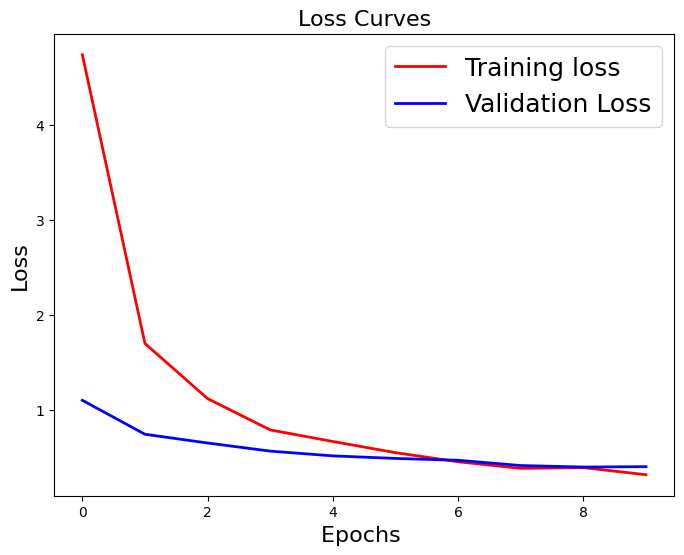

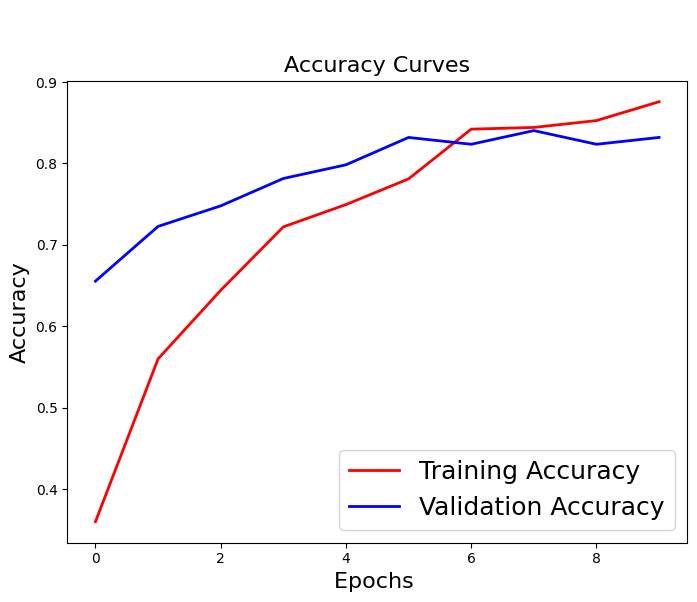

In [7]:
#Re-trained model's performance check

# Evaluate the model (loss, accuracy)
loss, accuracy = model.evaluate(test)
print(f'Test accuracy: {accuracy:.2f}')

#plot loss and accuracy graph
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=2.0)
plt.plot(history.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=2.0)
plt.plot(history.history['val_acc'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('\n\nAccuracy Curves',fontsize=16)

In [9]:
#Inference/testing phase

#Predicted outputs
prediction=model.predict(test,verbose=1)

#store each images's highest score class
predicted_class=np.argmax(prediction,axis=1)
print("\nPredicted outputs :-\n",predicted_class)


#Target outputs
target_class=[]
for idx,batch in enumerate(test):
  images,labels=batch
  for label in labels:
    target_class.append(int(label))

print("\nTarget outputs :-\n",target_class)

#computing the number of errors - predicting wrong classes
errors=0
tot=len(target_class)
for i in range(0,len(predicted_class)):
  if predicted_class[i]!=target_class[i]:
    errors=errors+1
print("\nAccuracy of the model is",round(float(((100-errors)*tot)/100),2),"%")
print("Total number of errors",errors)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step

Predicted outputs :-
 [1 2 2 0 1 1 2 1 2 0 2 1 0 2 2 2 0 2 2 3 1 1 0 0 2 2 2 2 2 0 2 1 2 1 2 1 1
 2 2 0 2 2 1 1 1 0 1 0 2 0 2 1 0 2 0 0 2 2 0 2 1 0 1 2 1 2 0 2 2 0 2 1 0 2
 2 2 2 1 3 0 3 2 0 2 2 0 2 1 3 2 1 1 2 2 2 0 0 3 1 1 2 0 2 1 1 2 2 2 0 0 0
 1 0 1 3 1 2 0 0]

Target outputs :-
 [1, 2, 2, 0, 1, 1, 2, 1, 0, 0, 2, 1, 0, 2, 2, 2, 0, 2, 2, 3, 1, 1, 0, 0, 0, 0, 2, 2, 2, 0, 2, 3, 2, 1, 2, 1, 1, 2, 2, 0, 2, 0, 1, 1, 1, 0, 1, 0, 2, 0, 2, 1, 2, 2, 0, 0, 2, 0, 2, 0, 1, 0, 1, 0, 1, 2, 0, 2, 2, 0, 2, 1, 0, 2, 2, 2, 2, 1, 3, 2, 3, 1, 2, 2, 3, 0, 2, 1, 3, 3, 1, 1, 2, 3, 2, 0, 2, 3, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 0, 0, 0, 1, 0, 1, 3, 1, 1, 0, 0]

Accuracy of the model is 95.2 %
Total number of errors 20
